In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [ ]:
from google.colab import files
from IPython.display import Image

In [ ]:
#We are using the image of HORSE
url = 'https://tse4.mm.bing.net/th?id=OIP._7oANUp2HG1KXyiuDDs9hAHaKm&pid=Api&P=0&h=180'
# Download an image and read it into a NumPy array.
def download(url, target_size=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
  return img

In [ ]:
#Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

4411/4411 [==============================] - 0s 0us/step


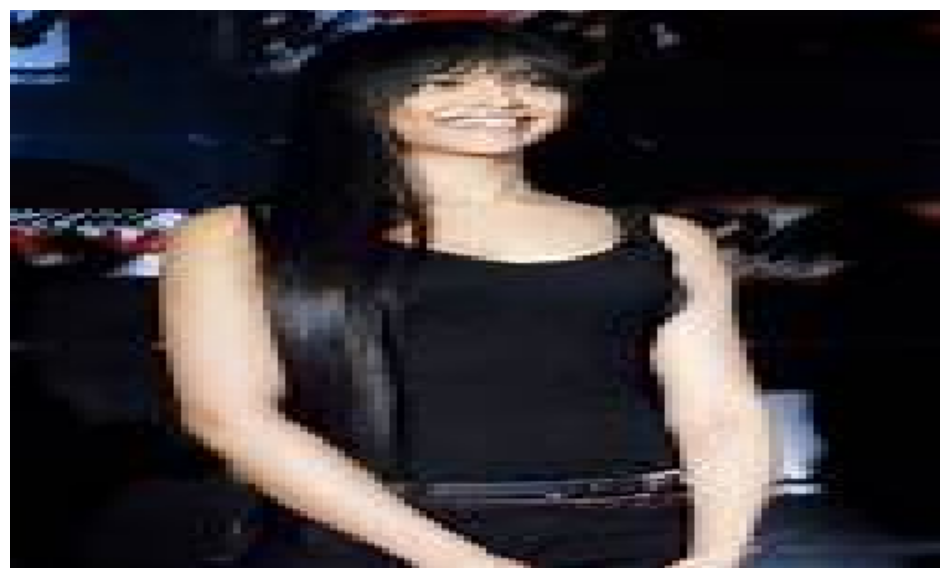

In [ ]:
# Display an image
def show(img):
  plt.figure(figsize=(12,12))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img)
  plt.show()
# Downsizing the image makes it easier to work with.
original_img = download(url, target_size=[225, 375])
original_img = np.array(original_img)
show(original_img)

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [ ]:
@tf.function
def deepdream(model, img, steps, step_size):
    with tf.GradientTape() as tape:
      # This needs gradients relative to `img`
      # `GradientTape` only watches `tf.Variable`s by default
      tape.watch(img)
      loss = calc_loss(img, model)

    # Calculate the gradient of the loss with respect to the pixels of the input image.
    gradients = tape.gradient(loss, img)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8

    # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
    # You can update the image by directly adding the gradients (because they're the same shape!)
    img = img + gradients*step_size
    img = tf.clip_by_value(img, -1, 1)
    return loss, img

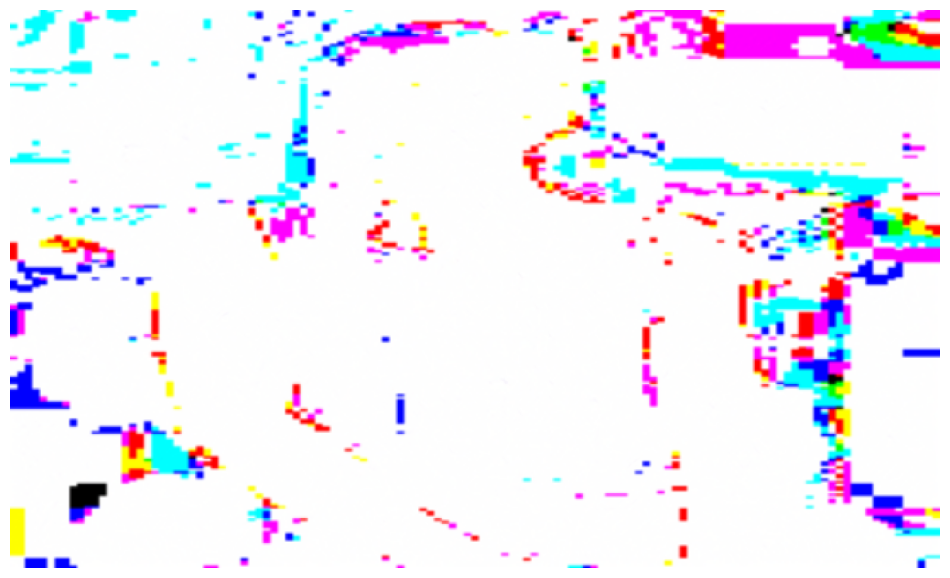

In [ ]:
OCTAVE_SCALE = 1.3

img = tf.constant(np.array(original_img))
base_shape = tf.cast(tf.shape(img)[:-1], tf.float32)

for n in range(3):
  new_shape = tf.cast(base_shape*(OCTAVE_SCALE**n), tf.int32)



  img = tf.image.resize(img, new_shape).numpy()

  loss, img = deepdream(model=dream_model, img=img, steps=200, step_size=0.001)


clear_output(wait=True)
show(img)

In [ ]:
img.shape

TensorShape([380, 633, 3])

In [ ]:
dream_model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7ad8688ffc40>>